In [1]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

TF version: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive

' '
'~.'
 1000052120.png
'10 (1).py'
 106105191.gdoc
 10.py
'113995 (2).gdoc'
'1 (1).py'
 121286.pdf
 146-compressed.pdf
 1838.gsheet
 1.py
'2 (1).py'
'2marks aai.gdoc'
 2.py
'3 (1).py'
 3.py
'4 (1).py'
 4.py
'505_5730453 (1) (1).PDF'
'505_5730453 (1).PDF'
 505_5730453.PDF
'5 (1).py'
 59c3e94e-7486-4cdd-bdaa-eb2d361662b5.pdf
 5.pdf
 5.py
'6 (1).py'
 6.pdf
 6.py
'7 (1).py'
 7.py
'8 (1).py'
 8.py
'9 (1).py'
 9.py
'aadhar card.pdf'
'AAI Model 1.docx'
'AAI Model 1.gdoc'
'ACE Scanner_2024_04_30 (2).pdf'
 Application_379726.pdf
'Audio from sathvika'
 Brain_Tumor_Classification_using_EfficientNet-B0_Model.pdf
 brain_tumor_dataset_info.gdoc
'c1 (1).pdf'
 c1.pdf
'c2 (1).pdf'
'c2 (2).pdf'
 c2.pdf
'c3 (1).pdf'
 c3.pdf
'c4 (1).pdf'
 c4.pdf
'c5 (1).pdf'
 c5.pdf
 c6.pdf
'Colab Notebooks'
'COLLEGE RANKING BASED ON PERCEPTION.pdf'
'Company Wise DSA Questions'
'Copy of 59c3e94e-7486-4cdd-bdaa-eb2d361662b5.pdf'
'Copy of 6.pdf'
'Copy of 7642b00aab2e1084fa2f6be68d35dcddd901e15d8b6976168245a58493092fbb.0.W

In [4]:
!unzip -q /content/drive/MyDrive/pre_processed_brain-tumor-dataset.zip -d /content/pre_processed_brain_tumor_dataset

In [5]:
import os

# Root dataset folder
dataset_dir = "/content/pre_processed_brain_tumor_dataset/pre_processed_brain-tumor-dataset"

# List root folders
print("Root folders:", os.listdir(dataset_dir))  # Should show: ['Training', 'Validation', 'Testing']


train_dir = os.path.join(dataset_dir, "Training")
train_classes = os.listdir(train_dir)
print("Classes in training set:", train_classes)

# Number of images per class
for cls in train_classes:
    cls_path = os.path.join(train_dir, cls)
    num_images = len(os.listdir(cls_path))
    print(f"{cls}: {num_images} images")


Root folders: ['Training', 'Testing', 'Validation']
Classes in training set: ['notumor', 'meningioma', 'glioma', 'pituitary']
notumor: 1595 images
meningioma: 1339 images
glioma: 1321 images
pituitary: 1457 images


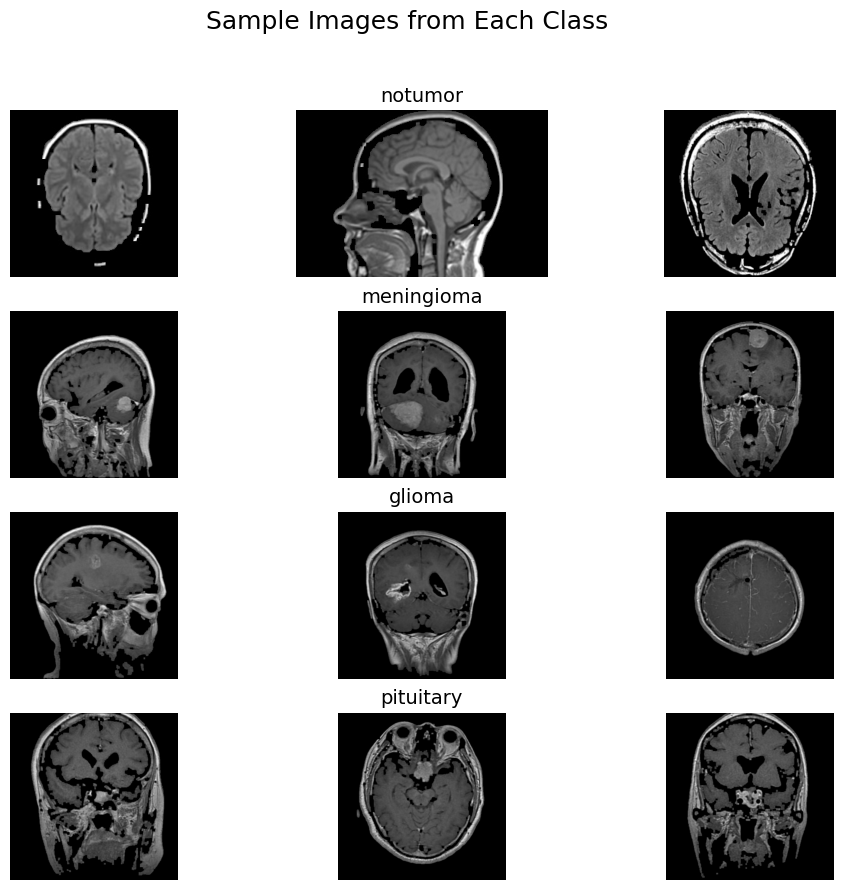

In [6]:
import matplotlib.pyplot as plt
import cv2
import os

# Use the same training directory defined earlier
train_path = train_dir
classes = os.listdir(train_path)

n_samples = 3
plt.figure(figsize=(12, 10))

for i, cls in enumerate(classes):
    folder = os.path.join(train_path, cls)
    images = os.listdir(folder)[:n_samples]

    for j, img_name in enumerate(images):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(classes), n_samples, i * n_samples + j + 1)
        plt.imshow(img)
        plt.axis("off")
        if j == 1:
            plt.title(cls, fontsize=14)

plt.suptitle("Sample Images from Each Class", fontsize=18)
plt.show()


In [7]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import os
from tensorflow.keras.applications.efficientnet import preprocess_input

# Paths to your folders (case-sensitive)
dataset_dir = "/content/pre_processed_brain_tumor_dataset/pre_processed_brain-tumor-dataset"
train_dir = os.path.join(dataset_dir, "Training")
val_dir = os.path.join(dataset_dir, "Validation")
test_dir = os.path.join(dataset_dir, "Testing")

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Build datasets
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Optional: Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = raw_train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Data augmentation (only for training)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

class_names = raw_train_ds.class_names
print("Classes:", class_names, "Total:", len(class_names))

# Apply augmentation to training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

print("Datasets ready!")

# Then apply EfficientNet preprocessing for all datasets
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds   = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds  = test_ds.map(lambda x, y: (preprocess_input(x), y))

#Finally, prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.prefetch(buffer_size=AUTOTUNE)




Found 5712 files belonging to 4 classes.
Found 1055 files belonging to 4 classes.
Found 256 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary'] Total: 4
Datasets ready!


In [8]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load EfficientNet-B0 WITHOUT pretrained weights
base_model_scratch = EfficientNetB0(weights=None, include_top=False, input_shape=(224, 224, 3))

# Add custom classification head
x = base_model_scratch.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)


# Build final model
model_scratch = Model(inputs=base_model_scratch.input, outputs=predictions)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Compile model
model_scratch.compile(
    optimizer=Adam(learning_rate=0.001),  # Default Adam learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy', precision_m, recall_m, f1_m]
)

model_scratch.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ normalization[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 4,336,512 (16.54 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [9]:
from tensorflow.keras.applications import EfficientNetB0  # ✅ Use EfficientNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load base EfficientNetB0 model (pretrained on ImageNet)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers (so they don't retrain initially)
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)  # ✅ use len(classes) instead of train_gen.num_classes

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', precision_m, recall_m, f1_m]
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_2[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks for EfficientNetB0 training
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,                # wait 5 epochs for improvement
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,                # reduce LR by 30%
    patience=3,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'efficientnetb0_brain_tumor.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
callbacks = [early_stop, reduce_lr, checkpoint]

print("Callbacks for EfficientNetB0 are ready!")


Callbacks for EfficientNetB0 are ready!


In [11]:
# Number of epochs for initial training (feature extraction stage)
EPOCHS_STAGE1 = 20

# Train EfficientNetB0 (feature extraction stage)
history_stage1 = model.fit(
    train_ds,                  # training dataset
    validation_data=val_ds,    # validation dataset
    epochs=EPOCHS_STAGE1,
    callbacks=callbacks,
    verbose=1
)

print("Stage 1 training (feature extraction) complete!")


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.5306 - f1_m: 0.3927 - loss: 1.0794 - precision_m: 0.6473 - recall_m: 0.3050
Epoch 1: val_loss improved from inf to 0.60139, saving model to efficientnetb0_brain_tumor.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 147s 638ms/step - accuracy: 0.5313 - f1_m: 0.3939 - loss: 1.0780 - precision_m: 0.6480 - recall_m: 0.3061 - val_accuracy: 0.7611 - val_f1_m: 0.7334 - val_loss: 0.6014 - val_precision_m: 0.7874 - val_recall_m: 0.6941 - learning_rate: 1.0000e-04
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.7943 - f1_m: 0.7812 - loss: 0.5426 - precision_m: 0.8391 - recall_m: 0.7325
Epoch 2: val_loss improved from 0.60139 to 0.55129, saving model to efficientnetb0_brain_tumor.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 85s 438ms/step - accuracy: 0.7944 - f1_m: 0.7813 - loss: 0.5424 - precision_m: 0.8391 - recall_m: 0.7327 - val_accuracy: 0.7801 - val_f1_m: 0.7651 - val_loss: 0.5513 - val_precision_m: 0.7892 - val_recall_m: 0.74

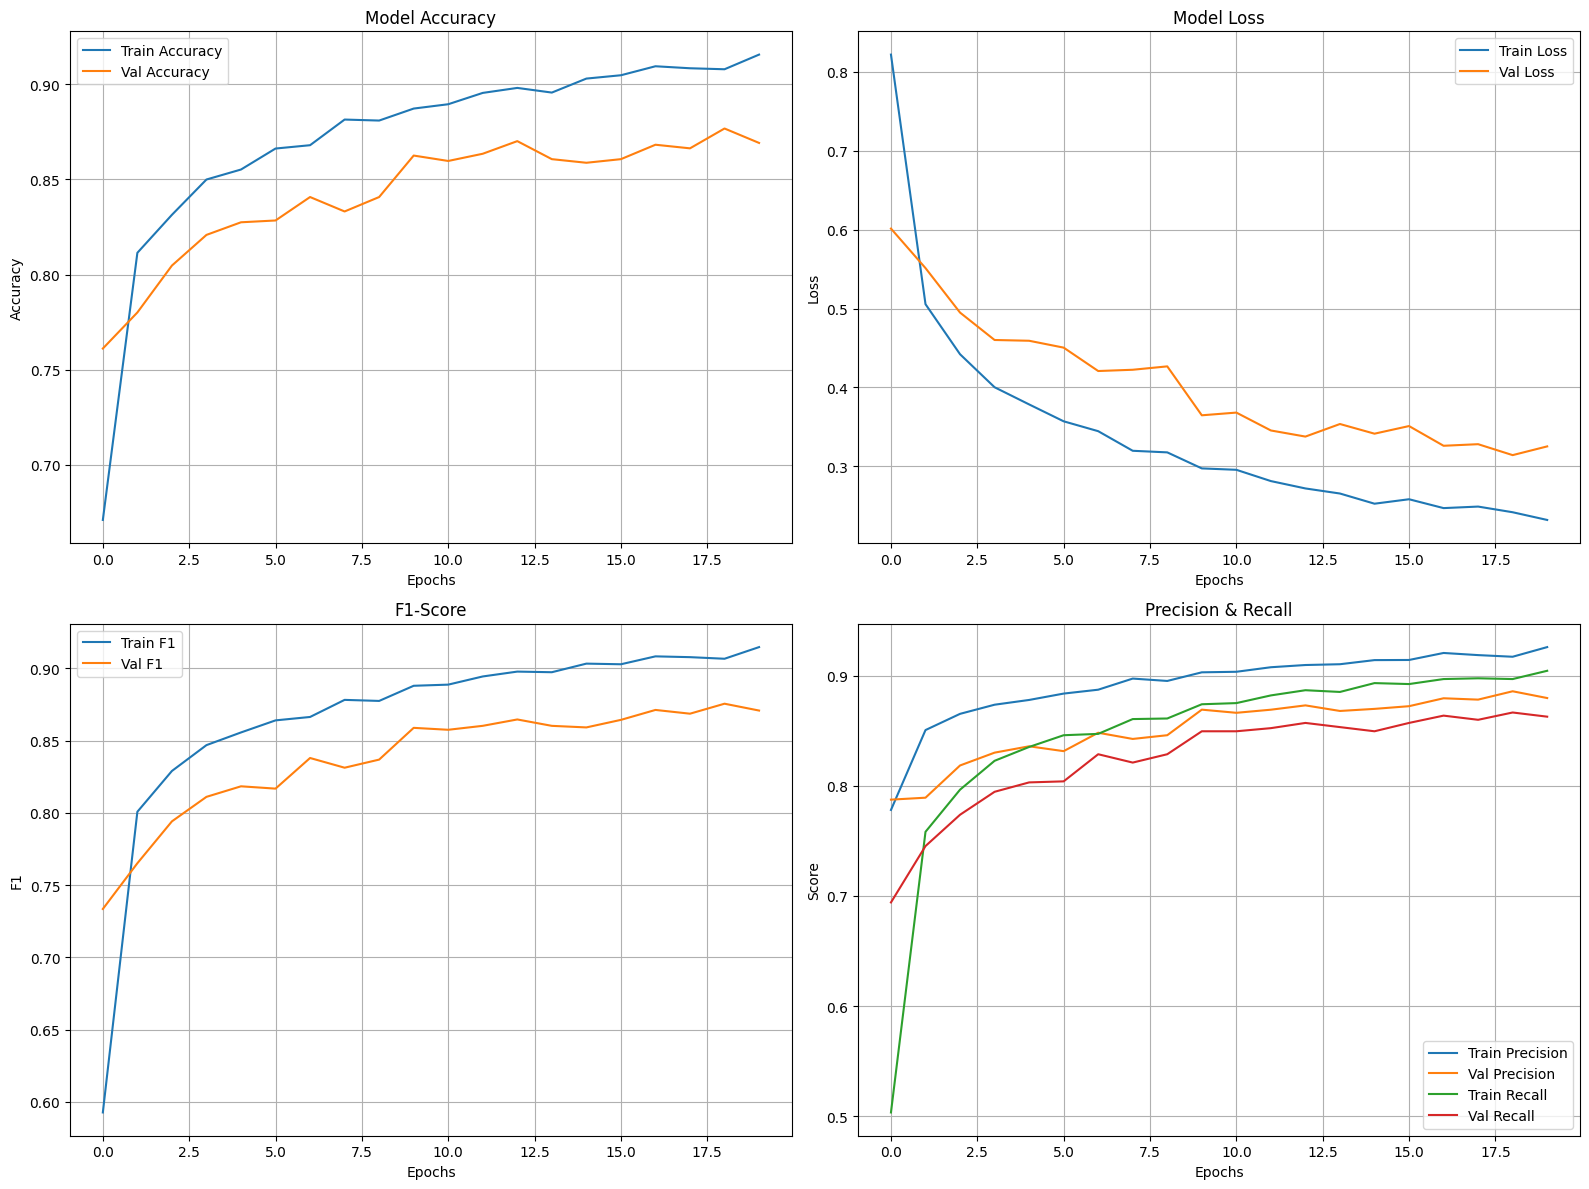

In [12]:
import matplotlib.pyplot as plt

# Plot helper function
def plot_training_history(history):
    # Convert history to dict for easier access
    hist = history.history

    plt.figure(figsize=(16, 12))

    # Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(hist['accuracy'], label='Train Accuracy')
    plt.plot(hist['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(2, 2, 2)
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # F1-Score
    if 'f1_m' in hist:
        plt.subplot(2, 2, 3)
        plt.plot(hist['f1_m'], label='Train F1')
        plt.plot(hist['val_f1_m'], label='Val F1')
        plt.title('F1-Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1')
        plt.legend()
        plt.grid(True)

    #  Precision & Recall (Optional)
    if 'precision_m' in hist and 'recall_m' in hist:
        plt.subplot(2, 2, 4)
        plt.plot(hist['precision_m'], label='Train Precision')
        plt.plot(hist['val_precision_m'], label='Val Precision')
        plt.plot(hist['recall_m'], label='Train Recall')
        plt.plot(hist['val_recall_m'], label='Val Recall')
        plt.title('Precision & Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function with your training history
plot_training_history(history_stage1)


In [13]:
# === Fine-Tuning Step ===

# Unfreeze the base EfficientNet model
for layer in base_model.layers:
    layer.trainable = True   # unfreeze all layers

# Re-compile with a smaller learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),   # much smaller LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy', precision_m, recall_m, f1_m]
)

# Number of fine-tuning epochs
EPOCHS_STAGE2 = 10

# Train again (starting from pretrained weights of Stage 1)
history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    callbacks=callbacks
)


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.7293 - f1_m: 0.6935 - loss: 0.7073 - precision_m: 0.8153 - recall_m: 0.6092
Epoch 1: val_loss did not improve from 0.31421
179/179 ━━━━━━━━━━━━━━━━━━━━ 201s 704ms/step - accuracy: 0.7296 - f1_m: 0.6938 - loss: 0.7066 - precision_m: 0.8155 - recall_m: 0.6096 - val_accuracy: 0.8559 - val_f1_m: 0.8489 - val_loss: 0.4005 - val_precision_m: 0.8788 - val_recall_m: 0.8229 - learning_rate: 1.0000e-05
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.8587 - f1_m: 0.8468 - loss: 0.4102 - precision_m: 0.8834 - recall_m: 0.8141
Epoch 2: val_loss did not improve from 0.31421
179/179 ━━━━━━━━━━━━━━━━━━━━ 110s 421ms/step - accuracy: 0.8587 - f1_m: 0.8468 - loss: 0.4100 - precision_m: 0.8835 - recall_m: 0.8142 - val_accuracy: 0.7848 - val_f1_m: 0.7720 - val_loss: 0.5239 - val_precision_m: 0.8112 - val_recall_m: 0.7401 - learning_rate: 1.0000e-05
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.8774

In [14]:
model.save("/content/drive/MyDrive/efficientnetb0_brain_tumor.keras")
model_path = "/content/drive/MyDrive/efficientnetb0_brain_tumor.keras"


In [15]:
# List only model-related files
!ls -lh "/content/drive/MyDrive" | grep efficientnet


ls: '/content/drive/MyDrive/Company Wise DSA Questions': No such file or directory
-rw------- 1 root root   51M Sep 14 14:38 efficientnetb0_brain_tumor.keras


In [16]:
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import load_model


model_path = "/content/drive/MyDrive/efficientnetb0_brain_tumor.keras"

#  Load with custom metrics
model = load_model(model_path,
                   custom_objects={'precision_m': precision_m,
                                   'recall_m': recall_m,
                                   'f1_m': f1_m})

print("EfficientNetB0 model loaded successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
EfficientNetB0 model loaded successfully!


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.8797 - f1_m: 0.8791 - loss: 0.4496 - precision_m: 0.8887 - recall_m: 0.8704

===== Test Evaluation =====
Test Loss: 0.3321
Test Accuracy: 90.62%
Test Precision: 0.9158
Test Recall: 0.8984
Test F1-score: 0.9067
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']

===== Classification Report =====
              precision    recall  f1-score   support

      glioma       0.98      0.98      0.98        50
  meningioma       1.00      0.61      0.76        56
     notumor       0.83      1.00      0.91       100
   pituitary       0.94      0.98      0.96        50

    accuracy                           0.91       256
   macro avg       0.94      0.89      0.90       256
weighted avg       0.92      0.91      0.90       256



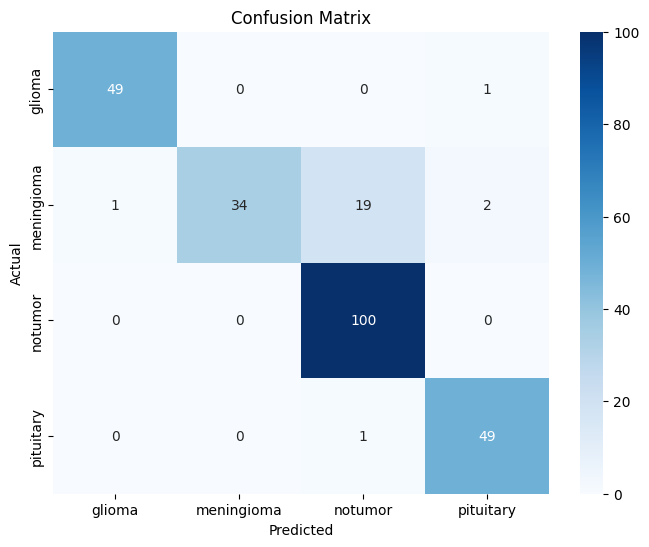

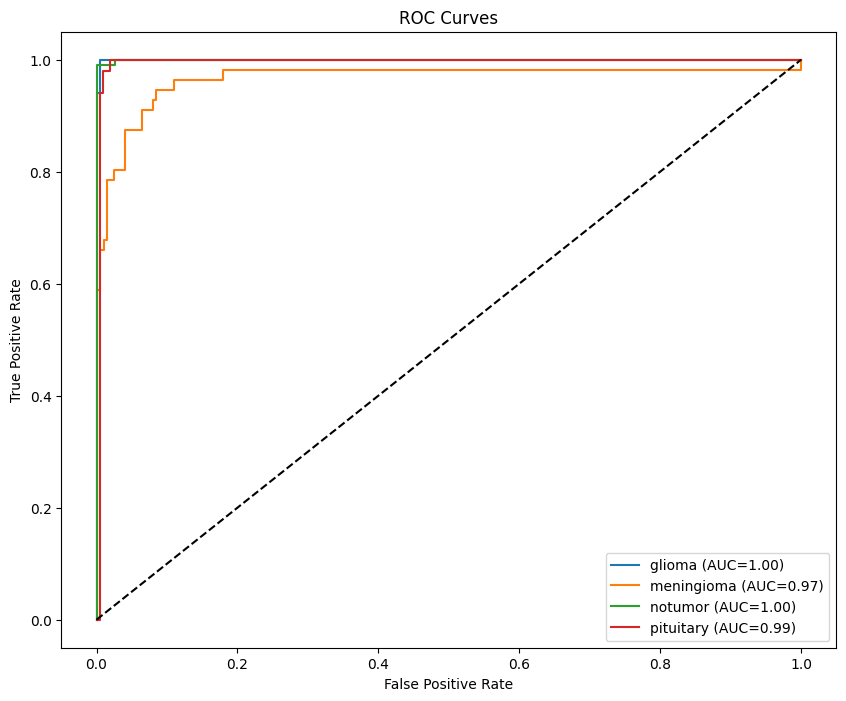

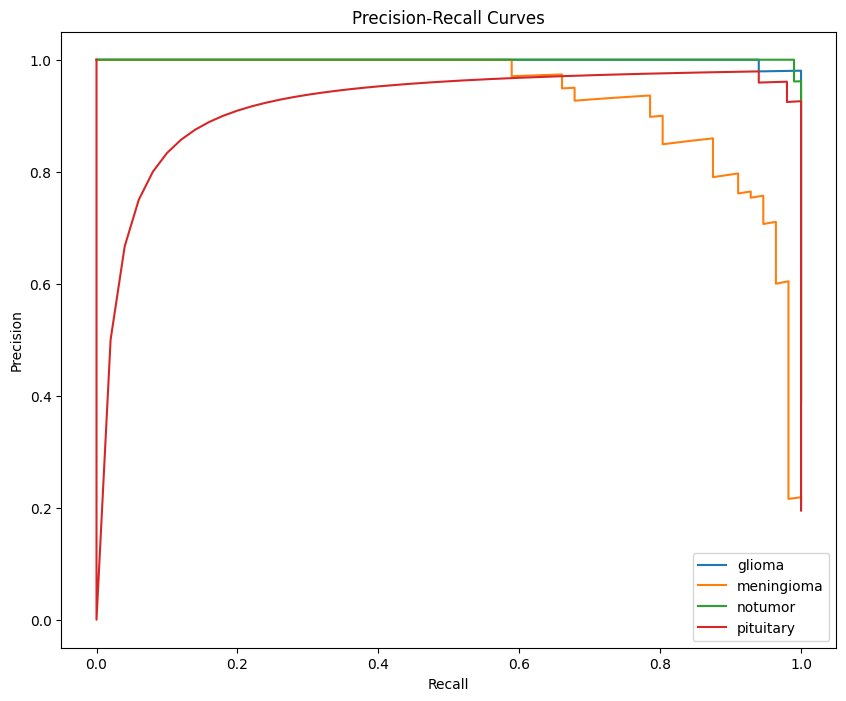

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from tensorflow.keras.utils import to_categorical

#  Evaluate on test_ds
test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(test_ds, verbose=1)

print("\n===== Test Evaluation =====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

#  Predictions
Y_prob = model.predict(test_ds)
y_pred = np.argmax(Y_prob, axis=1)

# True labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

# Class names (we stored this earlier)
print("Classes:", class_names)

# ===== Classification Report =====
print("\n===== Classification Report =====")
print(classification_report(y_true, y_pred, target_names=class_names))

# ===== Confusion Matrix =====
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ===== ROC Curves =====
y_true_cat = to_categorical(y_true, num_classes=len(class_names))
plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_cat[:,i], Y_prob[:,i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

# ===== Precision-Recall Curves =====
plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_true_cat[:,i], Y_prob[:,i])
    plt.plot(recall, precision, label=f"{class_names[i]}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()


In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

#  Step 1: Get predictions & true labels
Y_prob = model.predict(test_ds)
y_pred = np.argmax(Y_prob, axis=1)

# True labels (one-hot -> index)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

#  Step 2: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

#  Step 3: Per-class Accuracy = Correct predictions / Total samples per class
per_class_acc = cm.diagonal() / cm.sum(axis=1)

#  Step 4: Classification Report for precision, recall, f1
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

#  Step 5: Build DataFrame for clear tabular view
metrics_df = pd.DataFrame({
    "Class": class_names,
    "Accuracy": per_class_acc,
    "Precision": [report[c]["precision"] for c in class_names],
    "Recall": [report[c]["recall"] for c in class_names],
    "F1-Score": [report[c]["f1-score"] for c in class_names],
    "Support": [report[c]["support"] for c in class_names],
})

metrics_df["Accuracy"] = (metrics_df["Accuracy"] * 100).round(2)
metrics_df["Precision"] = (metrics_df["Precision"] * 100).round(2)
metrics_df["Recall"] = (metrics_df["Recall"] * 100).round(2)
metrics_df["F1-Score"] = (metrics_df["F1-Score"] * 100).round(2)

import pandas as pd
import IPython.display as display
display.display(metrics_df)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


,Class,Accuracy,Precision,Recall,F1-Score,Support
0,glioma,98.00,98.00,98.00,98.00,50.0
1,meningioma,60.71,100.00,60.71,75.56,56.0
2,notumor,100.00,83.33,100.00,90.91,100.0
3,pituitary,98.00,94.23,98.00,96.08,50.0
